In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
import torch
import torch.nn as nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

In [3]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [5]:
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
reviews = pd.read_csv('data/reviews.csv.zip', sep='\t')
reviews.drop_duplicates(subset=['review'], inplace=True)
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
5,Очень глубокие проймы,negative
6,Я недовольна заказом.Я вот одного не понимаю п...,negative
7,"заказала размер s на от 64,об 94,начнем с того...",negative
8,Заказ я сделала в июле. С тех пор посылка отсл...,negative
9,Ужасное качество товара!,negative


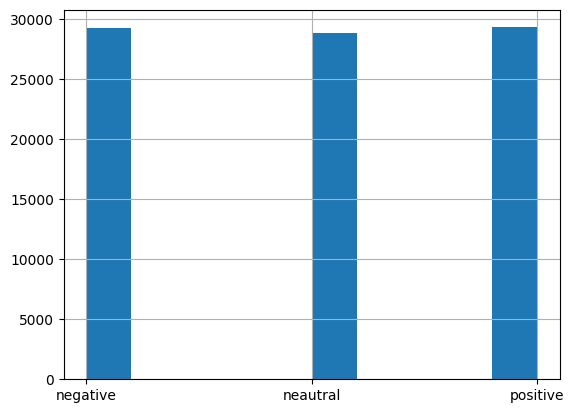

In [7]:
reviews.sentiment.hist()
plt.show()

In [8]:
sentiment_map = {
    'negative': 0,
    'neautral': 1,
    'positive': 2
}

In [9]:
reviews.sentiment = reviews.sentiment.apply(lambda x: sentiment_map[x])
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0
5,Очень глубокие проймы,0
6,Я недовольна заказом.Я вот одного не понимаю п...,0
7,"заказала размер s на от 64,об 94,начнем с того...",0
8,Заказ я сделала в июле. С тех пор посылка отсл...,0
9,Ужасное качество товара!,0


In [10]:
reviews_sample = reviews.sample(frac=0.15, replace=True, random_state=42)
reviews_sample.shape

(13098, 2)

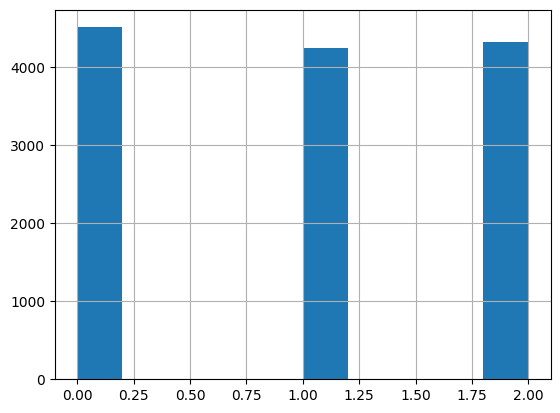

In [11]:
reviews_sample.sentiment.hist()
plt.show()

In [12]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [13]:
pretrained_model_name_or_path = 'sberbank-ai/rugpt3medium_based_on_gpt2'

In [14]:
gpt = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path)

In [15]:
gpt

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [16]:
for param in gpt.parameters():
    param.requires_grad = False

In [17]:
num_labels = reviews.sentiment.nunique()
num_labels

3

In [18]:
gpt.lm_head = nn.Linear(gpt.config.hidden_size, num_labels)
gpt = gpt.to(device)
gpt

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=3, bias=True)
)

In [19]:
X = reviews_sample.review
y = reviews_sample.sentiment

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
tokenizer.pad_token_id = 0
print(tokenizer.pad_token)

<pad>


In [22]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3):
        self.X = tokenizer(X.tolist(), 
                           truncation=True, 
                           padding=True,
                           return_tensors="pt",
                           max_length=2048).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [23]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer)

free_memory()

In [24]:
batch_size = 32
num_epochs = 15

In [25]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [26]:
optimizer = AdamW(gpt.lm_head.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [27]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.mean(outputs.logits, dim=1)
        _, indices = torch.max(logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del logits
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [28]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, 
                step_size=1, gamma=0.5):
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (input_ids, attention_mask, y) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = torch.mean(outputs.logits, dim=1)
            optimizer.zero_grad()
            loss = criterion(logits, y)
            loss.backward()
            clip_grad_norm_(model.lm_head.parameters(), 1.0)
            optimizer.step()
            
            _, indices = torch.max(logits, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss
            
            del outputs
            del logits
            del indices
            del input_ids
            del attention_mask
            del y
            free_memory()
          
        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        free_memory()

        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))
        
    return loss_history, train_history

In [29]:
loss_history, train_history = train_model(gpt, 
                                          train_loader, 
                                          criterion, 
                                          optimizer, num_epochs)

Average loss: 0.830991, Train accuracy: 0.660145
Average loss: 0.665423, Train accuracy: 0.711014
Average loss: 0.601056, Train accuracy: 0.732964
Average loss: 0.569585, Train accuracy: 0.750525
Average loss: 0.554496, Train accuracy: 0.759401
Average loss: 0.540601, Train accuracy: 0.767799
Average loss: 0.537733, Train accuracy: 0.766368
Average loss: 0.535967, Train accuracy: 0.767131
Average loss: 0.532242, Train accuracy: 0.772571
Average loss: 0.531338, Train accuracy: 0.767704
Average loss: 0.530329, Train accuracy: 0.769422
Average loss: 0.533322, Train accuracy: 0.772094
Average loss: 0.530567, Train accuracy: 0.770376
Average loss: 0.532977, Train accuracy: 0.769517
Average loss: 0.532478, Train accuracy: 0.770662


In [30]:
free_memory()

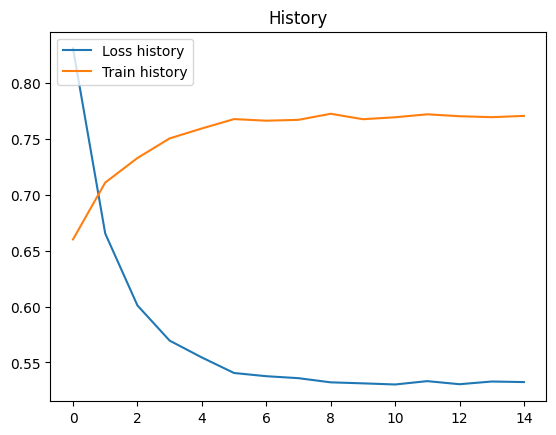

In [31]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.plot(train_history, label="Train history")
plt.legend(loc="upper left")
plt.show()

In [32]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
accuracy, f1 = evaluate_model(gpt, test_loader)
print(f"Test accuracy is {accuracy}")
print(f"Test f1 score is {f1}")

Test accuracy is 0.7293893129770992
Test f1 score is 0.723349162165072


In [34]:
torch.save(gpt, 'st_sberbank-gpt-sentiment-classifier_medium.pth')